# TORCH.NN 이 실제로 무엇인가요?
이 튜토리얼을 스크립트가 아닌 노트북으로 실행하기를 권장합니다. 노트북 (.ipynb) 파일을 다운 받으시려면, 페이지 상단에 있는 링크를 클릭해주세요.

PyTorch 는 여러분이 신경망(neural network)를 생성하고 학습시키는 것을 도와주기 위해서 torch.nn , torch.optim , Dataset , 그리고 DataLoader 와 같은 잘 디자인된 모듈과 클래스들을 제공합니다. 이들의 성능을 최대한 활용하고 여러분의 문제에 맞게 커스터마이즈하기 위해서, 정확히 이들이 어떤 작업을 수행하는지 이해할 필요가 있습니다. 이해를 증진하기 위해서, 우리는 먼저 이들 모델들로 부터 아무 피쳐도 사용하지 않고 MNIST 데이터셋에 대해 기초적인 신경망을 학습시킬 것입니다; 우리는 처음에는 가장 기초적인 PyTorch 텐서(tensor) 기능만을 사용할 것입니다. 그리고나서 우리는 점차적으로 torch.nn, torch.optim, Dataset, 또는 DataLoader 로부터 한번에 하나씩 피쳐를 추가하면서, 정확히 각 부분이 어떤 일을 하는지 그리고 이것이 어떻게 코드를 더 간결하고 유연하게 만드는지 보여줄 것입니다.

이 튜토리얼은 여러분이 이미 PyTorch를 설치하였고, 그리고 텐서 연산의 기초에 대해 익숙하다고 가정합니다. (만약 여러분이 NumPy 배열(array) 연산에 익숙하다면, 여기에서 사용되는 PyTorch 텐서 연산도 거의 동일하다는 것을 알게 될 것입니다).

## MNIST 데이터 준비
우리는 손으로 쓴 숫자(0에서 9 사이)의 흑백 이미지로 구성된 클래식 MNIST 데이터셋을 사용할 것 입니다.

우리는 경로 설정을 담당하는 (Python3 표준 라이브러리의 일부인) pathlib 을 사용할 것이고, requests 를 이용하여 데이터셋을 다운로드 할 것입니다. 우리는 모듈을 사용할 때만 임포트(import) 할 것이므로, 여러분은 매 포인트마다 정확히 어떤 것이 사용되는지 확인할 수 있습니다.

In [7]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

In [8]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

(50000, 784)


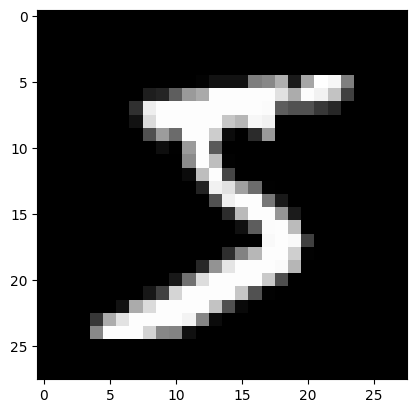

In [9]:
# 각 이미지는 28 x 28 형태 이고, 784 (=28x28) 크기를 가진 하나의 행으로 저장되어 있습니다. 
# 하나를 살펴 봅시다; 먼저 우리는 이 이미지를 2d로 재구성해야 합니다.

from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28,28)), cmap='gray')
print(x_train.shape)

In [34]:
# PyTorch는 NumPy 배열 보다는 torch.tensor 를 사용하므로, 
# 우리는 데이터를 변환해야 합니다.
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

C:\Users\user\AppData\Local\Temp\ipykernel_18040\2003510596.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train, y_train, x_valid, y_valid = map(


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


### ``torch.nn`` 없이 밑바닥부터 신경망 만들기
PyTorch 텐서 연산만으로 첫 모델을 만들어봅시다. 여러분이 신경망의 기초에 대해서 이미 익숙하다고 가정합니다. (만약 익숙하지 않다면 course.fast.ai 에서 학습할 수 있습니다).

PyTorch는 랜덤 또는 0으로만 이루어진 텐서를 생성하는 메소드를 제공하고, 우리는 간단한 선형 모델의 가중치(weights)와 절편(bias)을 생성하기 위해서 이것을 사용할 것입니다. 이들은 일반적인 텐서에 매우 특별한 한 가지가 추가된 것입니다: 우리는 PyTorch에게 이들이 기울기(gradient)가 필요하다고 알려줍니다. 이를 통해 PyTorch는 텐서에 행해지는 모든 연산을 기록하게 하고, 따라서 자동적으로 역전파(back-propagation) 동안에 기울기를 계산할 수 있습니다!

가중치에 대해서는 requires_grad 를 초기화(initialization) 다음에 설정합니다, 왜냐하면 우리는 해당 단계가 기울기에 포함되는 것을 원치 않기 때문입니다. (PyTorch에서 _ 다음에 오는 메소드 이름은 연산이 인플레이스(in-place)로 수행되는 것을 의미합니다.)

In [35]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

PyTorch의 기울기를 자동으로 계산해주는 기능 덕분에, 
Python 표준 함수 (또는 호출 가능한 객체)를 모델로 사용할 수 있습니다! 

그러므로 간단한 선형 모델을 만들기 위해서 단순한 행렬 곱셈과 브로드캐스트(broadcast) 덧셈을 사용하여 보겠습니다. 
또한, 우리는 활성화 함수(activation function)가 필요하므로, 
log_softmax 를 구현하고 사용할 것입니다. 

PyTorch에서 많은 사전 구현된 손실 함수(loss function), 활성화 함수들이 제공되지만, 일반적인 python을 사용하여 자신만의 함수를 쉽게 작성할 수 있음을 기억해주세요. 

PyTorch는 심지어 여러분의 함수를 위해서 빠른 GPU 또는 벡터화된 CPU 코드를 만들어줄 것입니다.

In [36]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

위에서, @ 기호는 행렬 곱셈(matrix multiplication) 연산을 나타냅니다. 
우리는 하나의 배치(batch) 데이터(이 경우에는 64개의 이미지들)에 대하여 함수를 호출할 것입니다. 

이것은 하나의 포워드 전달(forward pass) 입니다. 
이 단계에서 우리는 무작위(random) 가중치로 시작했기 때문에 우리의 예측이 무작위 예측보다 전혀 나은 점이 없을 것입니다.

In [37]:
bs = 64  # 배치 크기

xb = x_train[0:bs]  # x로부터 미니배치(mini-batch) 추출
preds = model(xb)  # 예측
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-2.2939, -2.2374, -2.3367, -2.6087, -2.8811, -2.3790, -2.8378, -2.8880,
        -1.7374, -1.6974], grad_fn=<SelectBackward0>) torch.Size([64, 10])


여러분이 보시듯이, preds 텐서(tensor)는 텐서 값 외에도, 또한 기울기 함수(gradient function)를 담고 있습니다. 

우리는 나중에 이것을 역전파(backpropagation)를 위해 사용할 것입니다. 
이제 손실함수(loss function)로 사용하기 위한 음의 로그 우도(negative log-likelihood)를 구현합시다. (다시 말하지만, 우리는 표준 Python을 사용할 수 있습니다.):

In [38]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [39]:
# 우리의 무작위 모델에 대한 손실을 점검해봅시다, 
# 그럼으로써 우리는 나중에 역전파 이후에 개선이 있는지 확인할 수 있습니다.
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.3533, grad_fn=<NegBackward0>)


In [40]:
# 또한, 우리 모델의 정확도(accuracy)를 계산하기 위한 함수를 구현합시다. 매 예측마다, 만약 가장 큰 값의 인덱스가 목표값(target value)과 동일하다면, 그 예측은 올바른 것입니다.
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

# 우리의 무작위 모델의 정확도를 점검해 봅시다, 그럼으로써 손실이 개선됨에 따라서 정확도가 개선되는지 확인할 수 있습니다.

print(accuracy(preds, yb))

tensor(0.1094)


이제 우리는 훈련 루프(training loop)를 실행할 수 있습니다. 매 반복마다, 우리는 다음을 수행할 것입니다:

- 데이터의 미니배치를 선택 (bs 크기)
- 모델을 이용하여 예측 수행
- 손실 계산

loss.backward() 를 이용하여 모델의 기울기 업데이트, 이 경우에는, weights 와 bias.

이제 우리는 이 기울기들을 이용하여 가중치와 절편을 업데이트 합니다. 
우리는 이것을 torch.no_grad() 컨텍스트 매니져(context manager) 내에서 실행합니다, 왜냐하면 이러한 실행이 다음 기울기의 계산에 기록되지 않기를 원하기 때문입니다. PyTorch의 자동 기울기(Autograd)가 어떻게 연산을 기록하는지 여기 에서 더 알아볼 수 있습니다.

우리는 그러고나서 기울기를 0으로 설정합니다, 그럼으로써 다음 루프(loop)에 준비하게 됩니다. 그렇지 않으면, 우리의 기울기들은 일어난 모든 연산의 누적 집계를 기록하게 되버립니다. (즉, loss.backward() 가 이미 저장된 것을 대체하기보단, 기존 값에 기울기를 더하게 됩니다).

In [41]:
from IPython.core.debugger import set_trace

lr = 0.5  # 학습률(learning rate)
epochs = 2  # 훈련에 사용할 에폭(epoch) 수

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        #         set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

이제 다 됐습니다: 우리는 제일 간단한 신경망(neural network)의 모든 것을 밑바닥부터 생성하고 훈련하였습니다! (이번에는 은닉층(hidden layer)이 없기 때문에, 로지스틱 회귀(logistic regression)입니다).

이제 손실과 정확도를 이전 값들과 비교하면서 확인해봅시다. 우리는 손실은 감소하고, 정확도는 증가하기를 기대할 것이고, 그들은 아래와 같습니다.

In [42]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0811, grad_fn=<NegBackward0>) tensor(1.)


### torch.nn.functional 사용하기
이제 우리는 코드를 리팩토링(refactoring) 하겠습니다, 그럼으로써 이전과 동일하지만, PyTorch의 nn 클래스의 장점을 활용하여 더 간결하고 유연하게 만들 것입니다. 지금부터 매 단계에서, 우리는 코드를 더 짧고, 이해하기 쉽고, 유연하게 만들어야 합니다.

처음이면서 우리의 코드를 짧게 만들기 가장 쉬운 단계는 직접 작성한 활성화, 손실 함수를 torch.nn.functional 의 함수로 대체하는 것입니다 (관례에 따라, 일반적으로 F 네임스페이스(namespace)를 통해 임포트(import) 합니다). 이 모듈에는 torch.nn 라이브러리의 모든 함수가 포함되어 있습니다 (라이브러리의 다른 부분에는 클래스가 포함되어 있습니다.) 다양한 손실 및 활성화 함수 뿐만 아니라, 풀링(pooling) 함수와 같이 신경망을 만드는데 편리한 몇 가지 함수도 여기에서 찾을 수 있습니다. (컨볼루션(convolution) 연산, 선형(linear) 레이어, 등을 수행하는 함수도 있지만, 앞으로 보시겠지만 일반적으로 라이브러리의 다른 부분을 사용하여 더 잘 처리 할 수 있습니다.)

만약 여러분들이 음의 로그 우도 손실과 로그 소프트맥스 (log softmax) 활성화 함수를 사용하는 경우, PyTorch는 이 둘을 결합하는 단일 함수인 F.cross_entropy 를 제공합니다. 따라서 모델에서 활성화 함수를 제거할 수도 있습니다.

In [43]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

In [44]:
# 더이상 model 함수에서 log_softmax 를 호출하지 않고 있습니다. 손실과 정확도과 이전과 동일한지 확인해봅시다:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0811, grad_fn=<NllLossBackward0>) tensor(1.)


### nn.Module 을 이용하여 리팩토링 하기
다음으로, 더 명확하고 간결한 훈련 루프를 위해 nn.Module 및 nn.Parameter 를 사용합니다. 우리는 nn.Module (자체가 클래스이고 상태를 추척할 수 있는) 하위 클래스(subclass)를 만듭니다. 이 경우에는, 포워드(forward) 단계에 대한 가중치, 절편, 그리고 메소드(method) 등을 유지하는 클래스를 만들고자 합니다. nn.Module 은 우리가 사용할 몇 가지 속성(attribute)과 메소드를 (.parameters() 와 .zero_grad() 같은) 가지고 있습니다.

In [45]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

함수를 사용하는 대신에 이제는 오브젝트(object) 를 사용하기 때문에, 먼저 모델을 인스턴스화(instantiate) 해야 합니다:

In [46]:
model = Mnist_Logistic()

이제 우리는 이전과 동일한 방식으로 손실을 계산할 수 있습니다. 여기서 nn.Module 오브젝트들은 마치 함수처럼 사용됩니다 (즉, 이들은 호출가능 합니다), 그러나 배후에서 PyTorch 는 우리의 forward 메소드를 자동으로 호출합니다.

In [47]:
print(loss_func(model(xb), yb))

tensor(2.3826, grad_fn=<NllLossBackward0>)


이전에는 훈련 루프를 위해 이름 별로 각 매개변수(parameter)의 값을 업데이트하고 다음과 같이 각 매개 변수에 대한 기울기들을 개별적으로 수동으로 0으로 제거해야 했습니다:

In [48]:
with torch.no_grad():
    weights -= weights.grad * lr
    bias -= bias.grad * lr
    weights.grad.zero_()
    bias.grad.zero_()

이제 우리는 model.parameters() 및 model.zero_grad() (모두 nn.Module 에 대해 PyTorch에 의해 정의됨)를 활용하여 이러한 단계를 더 간결하게 만들고, 특히 더 복잡한 모델에 대해서 일부 매개변수를 잊어 버리는 오류를 덜 발생시킬 수 있습니다:

In [50]:
with torch.no_grad():
    for p in model.parameters():
        if p.grad is not None:  # 그래디언트가 None이 아닌 경우에만 업데이트
            p -= p.grad * lr
    model.zero_grad() 

In [49]:
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()

TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

이제 이것을 나중에 다시 실행할 수 있도록 fit 함수로 작은 훈련 루프를 감쌀 것입니다.

In [51]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()

In [52]:
print(loss_func(model(xb), yb))

tensor(0.0825, grad_fn=<NllLossBackward0>)
